In [1]:
#IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Part 3: VALIDATOR to test
modifier and simulator working in dynamic way, with hardcoded ranges
* next step, extract the ranges 



** Sim y and Mod x output
 [ 2.          2.97435897  3.94871795  4.92307692  5.8974359   0.7
  0.8         0.5         0.2         1.5        11.74358974  1.2
  1.6         3.          4.         16.61538462 17.58974359 18.56410256
 19.53846154 20.51282051 21.48717949 22.46153846 23.43589744 24.41025641
 25.38461538 26.35897436 27.33333333 28.30769231 29.28205128 30.25641026
 31.23076923 32.20512821 33.17948718 34.15384615 35.12820513 36.1025641
 37.07692308 38.05128205 39.02564103 40.        ] 
 [ 1.          1.48717949  1.97435897  2.46153846  2.94871795  3.43589744
  3.92307692  4.41025641  4.8974359   5.38461538  5.87179487  6.35897436
  6.84615385  7.33333333  7.82051282  8.30769231  8.79487179  9.28205128
  9.76923077 10.25641026 10.74358974 11.23076923 11.71794872 12.20512821
 12.69230769 13.17948718 13.66666667 14.15384615 14.64102564 15.12820513
 15.61538462 16.1025641  16.58974359 17.07692308 17.56410256 18.05128205
 18.53846154 19.02564103 19.51282051 20.        ] 

       *

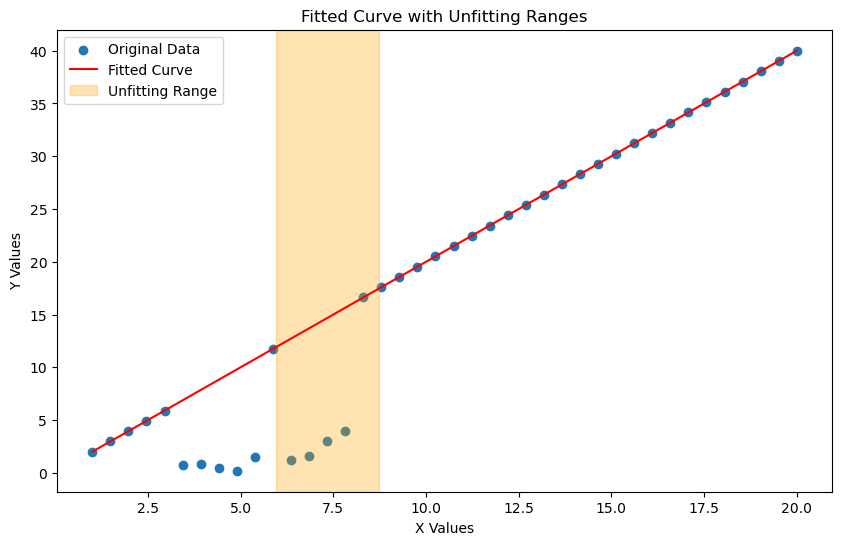

       *** OUTPUT unfitting_ranges [(5.9461538461538455, 8.72051282051282)] 

       *** OUTPUT validator_ranges [(5.9461538461538455, 8.72051282051282)] 

** Validator output
 [(5.9461538461538455, 8.72051282051282)] 


       *** USING local_exploration_validator_A
       *** USING fit_curve
       *** OUTPUT fit_curve slope, intercept 2.0000000024577886 -4.016827400646932e-08 

       *** USING generate_ranges_from_unfit_points
       *** OUTPUT unfit_ranges [(5.9461538461538455, 8.72051282051282)] 

       *** USING plot_curve


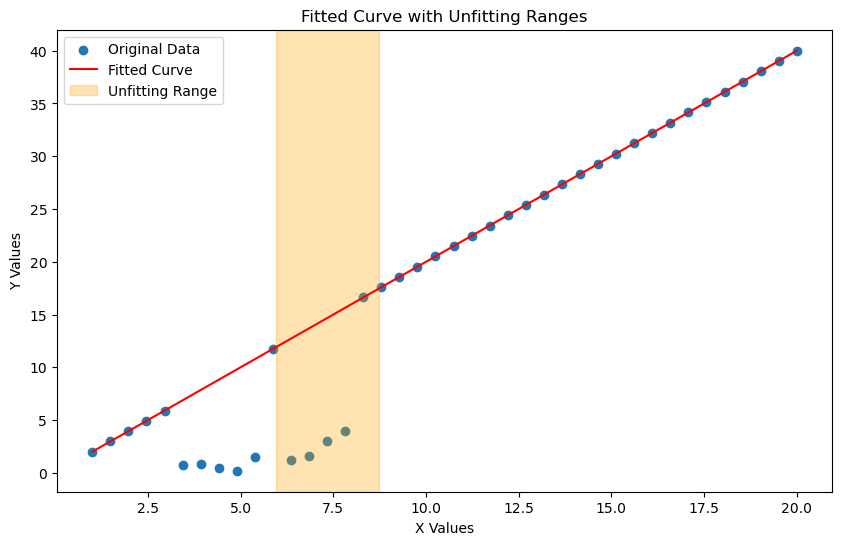

       *** OUTPUT unfitting_ranges [(5.9461538461538455, 8.72051282051282)] 

unfitting ranges
Points that least fit the curve: [(6.846153846153846, 1.6), (7.333333333333333, 3.0), (7.82051282051282, 4.0)]
Continuous ranges around least-fit points: [[6.480769230769231, 8.185897435897436]]


In [4]:
## VALIDATOR FILE: :
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler
from global_settings import fitting_threshold, mdv

class Validator:
    def __init__(self):
        self.iterations = 1
        self.total_points = 0
        self.total_bad_points = 0
        self.range = (mdv["domain_min_range"], mdv["domain_max_range"])
        self.num_points_evaluated = 0
        self.history = []  # Initialize history as an empty list

    @staticmethod
    def fit_curve(x_values, y_values, global_range=0):
        print('       *** USING fit_curve')
        
        x_values = np.array(x_values)  # Convert to numpy array
        y_values = np.array(y_values)  # Convert to numpy array

        # fit model
        model = HuberRegressor(epsilon=1)
        model.fit(x_values.reshape(-1, 1), y_values)

        # Get the coefficients of the fitted line
        slope = model.coef_[0]
        intercept = model.intercept_
        print('       *** OUTPUT fit_curve slope, intercept',slope, intercept,'\n')

        return slope, intercept


    def find_least_fit_points(x_values, y_values, degree):
        # # Fit a polynomial of the specified degree
        # coefficients = np.polyfit(x_values, y_values, degree)
        
        # # Calculate the predicted y-values using the polynomial
        # predicted_y_values = np.polyval(coefficients, x_values)
        
        # # Calculate the residuals (the differences between predicted and actual y-values)
        # residuals = y_values - predicted_y_values
        
        # # Find the indices of points with the largest residuals
        # least_fit_indices = np.argsort(np.abs(residuals))[-3:]  # Adjust the number as needed
        
        # # Create a list of points with the largest residuals
        # least_fit_points = [(x_values[i], y_values[i]) for i in least_fit_indices]
        
        # return least_fit_points
        # Fit a polynomial of the specified degree
        degree =2
        coefficients = np.polyfit(x_values, y_values, degree)
        
        # Calculate the predicted y-values using the polynomial
        predicted_y_values = np.polyval(coefficients, x_values)
        
        # Calculate the residuals (the differences between predicted and actual y-values)
        residuals = y_values - predicted_y_values
        
        # Find the indices of points with the largest residuals
        least_fit_indices = np.argsort(np.abs(residuals))[-3:]  # Adjust the number as needed
        
        # Create a list of points with the largest residuals
        least_fit_points = [(x_values[i], y_values[i]) for i in least_fit_indices]
        
        return least_fit_points

    def find_least_fit_ranges(least_fit_points, x_values, percentage=75):
        # Sort least-fit points based on x-values
        least_fit_points.sort(key=lambda point: point[0])
        
        # Calculate the interpoint interval
        interpoint_interval = np.diff(x_values).mean()
        
        # Calculate the continuous ranges around least-fit points
        least_fit_ranges = []
        current_range = None
        
        for point in least_fit_points:
            x_value = point[0]
            lower_bound = x_value - (percentage / 100) * interpoint_interval
            upper_bound = x_value + (percentage / 100) * interpoint_interval
            
            if current_range is None or lower_bound > current_range[1]:
                # Start a new range
                current_range = [lower_bound, upper_bound]
                least_fit_ranges.append(current_range)
            else:
                # Extend the current range
                current_range[1] = upper_bound
        
        return least_fit_ranges

    @staticmethod
    def generate_ranges_from_unfit_points(unfit_points, threshold):
        print('       *** USING generate_ranges_from_unfit_points')
        unfit_points.sort()  # Sort the unfit points based on x-values
        unfit_ranges = []

        current_start, current_end = unfit_points[0][0] - threshold, unfit_points[0][0] + threshold

        for i in range(1, len(unfit_points)):
            if unfit_points[i][0] - current_end <= threshold:
                current_end = unfit_points[i][0] + threshold
            else:
                unfit_ranges.append((current_start, current_end))
                current_start, current_end = unfit_points[i][0] - threshold, unfit_points[i][0] + threshold

        unfit_ranges.append((current_start, current_end))

        # Combine overlapping ranges
        combined_ranges = []

        for start, end in unfit_ranges:
            if combined_ranges and start <= combined_ranges[-1][1] + threshold:
                combined_ranges[-1] = (combined_ranges[-1][0], max(combined_ranges[-1][1], end))
            else:
                combined_ranges.append((start, end))

        print('       *** OUTPUT unfit_ranges', combined_ranges, '\n')
        return combined_ranges
    

    def update_num_points_evaluated(self, points, min_x, max_x):
        self.num_points_evaluated = len([(x, y) for x, y in points if min_x <= x <= max_x])

    @staticmethod
    def local_exploration_validator_A(x_values, y_values, global_range=[mdv["domain_min_range"], mdv["domain_max_range"]], threshold=fitting_threshold):
        print('       *** USING local_exploration_validator_A')
        fitted_curve = Validator.fit_curve(x_values, y_values, global_range)
        least_fit_points = Validator.find_least_fit_points(x_values, y_values, degree=2)
        # least_fit_ranges = Validator.generate_ranges_from_unfit_points(least_fit_points,threshold=0.75 )        # unfit_points = Validator.find_least_fit_points(x_values, y_values, fitted_curve, threshold=threshold)
        unfitting_ranges = Validator.generate_ranges_from_unfit_points(least_fit_points, threshold=threshold)
        # print(unfitting_ranges)
        # Validator.update_num_points_evaluated(len(x_values), min=global_range[0], max=global_range[1])
        Validator.save_to_text_file('output.txt', least_fit_points, unfitting_ranges)
        Validator.plot_curve(x_values, y_values, fitted_curve, unfitting_ranges)

        print('       *** OUTPUT unfitting_ranges',unfitting_ranges,'\n')
        return unfitting_ranges

    @staticmethod
    def save_to_text_file(filename, least_fit_points, unfitting_ranges):
        with open(filename, 'w') as file:
            file.write("Least Fit Points:\n")
            for point in least_fit_points:
                file.write(f"{point[0]}, {point[1]}\n")

            file.write("\nUnfitting Ranges:\n")
            for start, end in unfitting_ranges:
                file.write(f"{start} to {end}\n")

    @staticmethod
    def validator_controller(mod_x_list, sim_y_list, global_range=[mdv["domain_min_range"], mdv["domain_max_range"]], threshold=fitting_threshold, local_validator=local_exploration_validator_A, do_plot=False):
        print('       *** USING validator_controller')

        validator_ranges = local_validator(mod_x_list, sim_y_list, global_range=[mdv["domain_min_range"], mdv["domain_max_range"]], threshold=threshold)
        print('       *** OUTPUT validator_ranges',validator_ranges,'\n')
        return validator_ranges

    @staticmethod
    def thresholding(fitted_curve, threshold):
        print('       *** USING thresholding')
        x_values = np.arange(len(fitted_curve))
        y_values = np.array(fitted_curve)
        above_threshold = x_values[y_values > threshold]
        print('       *** OUTPUT above_threshold',above_threshold,'\n')
        return above_threshold


    @staticmethod
    def plot_curve(x_values, y_values, fitted_curve, unfitting_ranges):
        print('       *** USING plot_curve')
        plt.figure(figsize=(10, 6))

        # Plot the original x_values, y_values data
        plt.scatter(x_values, y_values, label='Original Data')

        # Plot the fitted curve
        plt.plot(x_values, fitted_curve[0] * x_values + fitted_curve[1], color='red', label='Fitted Curve')

        # Highlight the unfitting ranges
        for start, end in unfitting_ranges:
            plt.axvspan(start, end, color='orange', alpha=0.3, label='Unfitting Range')

        plt.xlabel('X Values')
        plt.ylabel('Y Values')
        plt.title('Fitted Curve with Unfitting Ranges')
        plt.legend()
        plt.show()

### TEST CASE:
# Generate x values
mod_x = np.linspace(1,20,40)
# Generate y values
sim_y_list = mod_x*2

# Add two ranges of outliers
outliers_indices = [5,6,7,8,9, 11,12,13,14]
outliers_values = np.array([0.7,0.8,0.5,0.2,1.5, 1.2,1.6,3,4])

sim_y_list[outliers_indices] = outliers_values
print('** Sim y and Mod x output\n', sim_y_list,'\n',mod_x,'\n') 


# Extracting x and y values for plotting
x_values = mod_x
y_values = sim_y_list

# Fitting the curve for plotting
fitted_curve = Validator.fit_curve(x_values, y_values)

output = Validator.validator_controller(mod_x_list=x_values,sim_y_list=y_values,threshold=0.9)
print('** Validator output\n', output,'\n\n') 

# Getting unfitting ranges for plotting
unfitting_ranges = Validator.local_exploration_validator_A(x_values, y_values)
print("unfitting ranges")
# Plotting the results


# Example usage
# x_values = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])
# y_values = np.array([1., 4., 9., 16., 25., 36., 0.8, 64., 1.5, 100., 121., 1.2, 1.6, 3., 4., 256., 289., 324., 361., 400.])

degree = 2  # You can adjust the degree of the polynomial fit

least_fit_points = Validator.find_least_fit_points(x_values, y_values, degree)
least_fit_ranges = Validator.find_least_fit_ranges(least_fit_points, x_values)

print("Points that least fit the curve:", least_fit_points)
print("Continuous ranges around least-fit points:", least_fit_ranges)



Points that least fit the curve: [(11.0, 121.0), (14.0, 3.0), (15.0, 4.0)]
Continuous ranges around least-fit points: [[10.25, 11.75], [13.25, 15.75]]
       *** USING fit_curve
       *** OUTPUT fit_curve slope, intercept 16.28020387341794 -57.63521230738858 

       *** USING validator_controller
       *** USING local_exploration_validator_A
       *** USING fit_curve
       *** OUTPUT fit_curve slope, intercept 16.28020387341794 -57.63521230738858 

       *** OUTPUT unfitting_ranges [(12.1, 15.9)] 

       *** OUTPUT validator_ranges [(12.1, 15.9)] 

** Validator output
 [(12.1, 15.9)] 


       *** USING local_exploration_validator_A
       *** USING fit_curve
       *** OUTPUT fit_curve slope, intercept 16.28020387341794 -57.63521230738858 

       *** OUTPUT unfitting_ranges [(12.1, 15.9)] 

unfitting ranges
       *** USING plot_curve


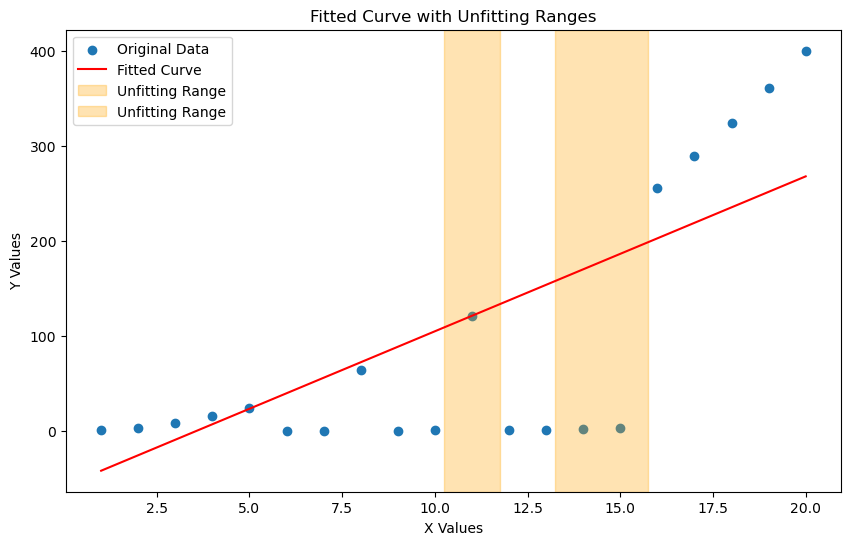

In [ ]:
import numpy as np

def find_least_fit_points(x_values, y_values, degree):
    # Fit a polynomial of the specified degree
    coefficients = np.polyfit(x_values, y_values, degree)
    
    # Calculate the predicted y-values using the polynomial
    predicted_y_values = np.polyval(coefficients, x_values)
    
    # Calculate the residuals (the differences between predicted and actual y-values)
    residuals = y_values - predicted_y_values
    
    # Find the indices of points with the largest residuals
    least_fit_indices = np.argsort(np.abs(residuals))[-3:]  # Adjust the number as needed
    
    # Create a list of points with the largest residuals
    least_fit_points = [(x_values[i], y_values[i]) for i in least_fit_indices]
    
    return least_fit_points

def find_least_fit_ranges(least_fit_points, x_values, percentage=75):
    # Sort least-fit points based on x-values
    least_fit_points.sort(key=lambda point: point[0])
    
    # Calculate the interpoint interval
    interpoint_interval = np.diff(x_values).mean()
    
    # Calculate the continuous ranges around least-fit points
    least_fit_ranges = []
    current_range = None
    
    for point in least_fit_points:
        x_value = point[0]
        lower_bound = x_value - (percentage / 100) * interpoint_interval
        upper_bound = x_value + (percentage / 100) * interpoint_interval
        
        if current_range is None or lower_bound > current_range[1]:
            # Start a new range
            current_range = [lower_bound, upper_bound]
            least_fit_ranges.append(current_range)
        else:
            # Extend the current range
            current_range[1] = upper_bound
    
    return least_fit_ranges

# Example usage
# Generate x values
mod_x = np.linspace(1,20,20)
# print(mod_x)
# Generate y values resembling a parabola shape
sim_y_list = mod_x**2

# Add four outliers
outliers_indices = [5,6, 8,9, 11,12,13,14]
outliers_values = np.array([0.7,0.8, 0.2,1.5, 1.2,1.6,3,4])
sim_y_list[outliers_indices] = outliers_values

x_values = mod_x
y_values = sim_y_list

degree = 2  # You can adjust the degree of the polynomial fit

least_fit_points = find_least_fit_points(x_values, y_values, degree)
least_fit_ranges = find_least_fit_ranges(least_fit_points, x_values)

print("Points that least fit the curve:", least_fit_points)
print("Continuous ranges around least-fit points:", least_fit_ranges)


# Fitting the curve for plotting
fitted_curve = Validator.fit_curve(x_values, y_values)

output = Validator.validator_controller(mod_x_list=x_values,sim_y_list=y_values,threshold=0.9)
print('** Validator output\n', output,'\n\n') 

# Getting unfitting ranges for plotting
unfitting_ranges = Validator.local_exploration_validator_A(x_values, y_values)
print("unfitting ranges")
# Plotting the results
Validator.plot_curve(x_values, y_values, fitted_curve, least_fit_ranges)


## PART 4: Main Func: with Modifier.py

In [4]:
# PLACEHOLDER FOR THE MAIN FUNCTION V2
%load_ext autoreload
%autoreload 2

from global_settings import mdv
# from Validator import Validator
from Modifier import Modifier
from Simulator import Simulator

print('* MDV: \n',mdv,'\n')

validate = Validator
modifier = Modifier
simulator = Simulator
appendedvars=[]

mainfunc=True
# Initialize interval list
interval_lists=[(mdv["domain_min_range"], mdv["domain_max_range"])]
x=1
while mainfunc==True:
    mod_x_list= modifier.modifier_controller(range_list=interval_lists,local_modifier=modifier.local_modifier_A, do_plot=False)

    if mod_x_list == False: # FALSE IF ["modifier_data_point"] < mdv["modifier_incremental_unit"]:
        print('*   ITERATIONS END HERE   *')
        break

    mod_x,sim_y_list = simulator.simulator_controller(mod_x_list,selected_function=simulator.sim_func_A)
    assert len(mod_x) == len(sim_y_list)
    
    print('\nValidator ...')
    ranges = Validator.validator_controller(mod_x_list=mod_x,sim_y_list=sim_y_list,threshold=0.9)
    interval_lists = ranges
    print('** Validator output\n', ranges,'\n\n') 


* MDV: 
 {'domain_min_range': 1, 'domain_max_range': 100, 'modifier_incremental_unit': 3, 'modifier_data_point': 10} 


Modifier controller...
  * Interval:  [(1, 100)]
     * Iterations within Modifier:  0
  * Mod_x shape:    (1, 10)

Simulator...
  * Sim_y shape:    (10,)

Validator ...
       *** USING validator_controller
       *** USING local_exploration_validator_A
       *** USING fit_curve
       *** OUTPUT fit_curve slope, intercept 7649.212914540916 -111811.06004977314 

       *** USING get_unfitting_point
       *** OUTPUT unfit_points [(2.4347826086956523, -3578.144751348419), (21.08695652173913, 9776.252437983245), (32.086956521739125, 35230.71369128723), (45.47826086956522, 104238.02783760903)] 

       *** USING generate_ranges_from_unfit_points
       *** OUTPUT unfit_ranges [(1.5347826086956524, 3.3347826086956522), (20.18695652173913, 21.986956521739128), (31.186956521739127, 32.986956521739124), (44.57826086956522, 46.37826086956522)] 

       *** OUTPUT unfitting_

/Users/lorafanda/Documents/Coding/AI/Davide/SimEx/SimEx/Modifier.py:16: RuntimeWarning: invalid value encountered in scalar divide
  new_values.append((((old_value - min(old_list)) * (new_max - new_min)) / (max(old_list) - min(old_list)))+ new_min)


ValueError: Input X contains NaN.
HuberRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values